In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mintpy.utils import readfile, utils as ut 
import h5py
import datetime
from mintpy.objects import timeseries
from mintpy.utils import time_func, readfile, utils as ut
from mintpy.dem_error import read_exclude_date, read_geometry
from scipy import linalg
from miaplpy.simulation import simulate_noise
from miaplpy.lib.utils import est_corr_py
from scipy.linalg import lapack as lap
from miaplpy.dev.modified_dem_error import estimate_dem_err_std

In [7]:
ts_file_s = '/Users/Sara/Library/CloudStorage/OneDrive-UniversityofMiami/Miami_final/with_dsm/timeseries.h5'
geom_file_s = '/Users/Sara/Library/CloudStorage/OneDrive-UniversityofMiami/Miami_final/with_dsm/geometryRadar.h5'


ts_file_t = '/Volumes/SaraMNew/scratch/minopy_subsets/1_PichinchaTsxDT004/timeseries.h5'
geom_file_t = '/Volumes/SaraMNew/scratch/minopy_subsets/1_PichinchaTsxDT004/geometryRadar.h5'

out_dir = './out_figures'


In [8]:
# Sentinel

ts_obj = timeseries(ts_file_s)
date_list_s = ts_obj.get_date_list()
metadata_s = ts_obj.get_metadata()
ts_obj.open()
length_s, width_s = ts_obj.length, ts_obj.width

# get date info
tbase_s = np.array(ts_obj.tbase, np.float32) #/ 365.25    
num_date_s = ts_obj.numDate

# 1.2 read geometry
sin_inc_angle_s, range_dist_s, pbase_s = read_geometry(ts_file_s, geom_file_s, box=None)

wavelength_s = np.float(metadata_s['radarWavelength'])

inc_angle_s = np.deg2rad(np.float(metadata_s['CENTER_INCIDENCE_ANGLE']))
heading_angle_s = np.deg2rad(np.float(metadata_s['HEADING']))

range_dist_s = np.nanmean(range_dist_s)
#sin_inc_angle_s = np.nanmean(sin_inc_angle_s)
sin_inc_angle_s = np.sin(inc_angle_s)

print(range_dist_s, sin_inc_angle_s)

seconds_s = ts_obj.get_metadata().get('CENTER_LINE_UTC', 0)

ex_date_list_s = []
date_flag_s = np.array([i not in ex_date_list_s for i in date_list_s],
                         dtype=np.bool_)


open timeseries file: timeseries.h5
open geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read mean bperp from timeseries file
1145777.8 0.6934290422221457


In [79]:
sigma_noise

11.328043295863225

In [76]:
phase2range = wavelength_s/(4*np.pi)

build_height=60
rep = 100
sigma_noise = 0.05 / phase2range # 0.7
G_geom_s = pbase_s / (range_dist_s * sin_inc_angle_s)

# prepare temporal deformation model
model = dict()
model['polynomial'] = 1
model['step'] = []
model['periodic'] = []


G_defo_s = time_func.get_design_matrix4time_func(date_list_s, model, seconds=seconds_s)
G_s = np.hstack((G_geom_s, G_defo_s))
#G_s = G_geom_s

recons_phi_topo_s = (4*np.pi/wavelength_s)*pbase_s*build_height/(sin_inc_angle_s*range_dist_s)
noise_s = np.random.randn(len(recons_phi_topo_s), 1)*sigma_noise
simulated_vector_s = (recons_phi_topo_s + noise_s)*phase2range

deltaz_s = []
dem_err_std_s = []


#ts_sigma = noise
ts_data_std_s = (noise_s*phase2range) 

w_s = 1/ts_data_std_s


nums = np.arange(5, 130)  #number of images


for t in range(rep):
    
    noise_s = np.random.randn(len(recons_phi_topo_s), 1)*sigma_noise
    simulated_vector_s = (recons_phi_topo_s + noise_s)*phase2range
    ts_data_std_s = (noise_s*phase2range) 
    w_s = 1/ts_data_std_s
    
    X_ss = np.zeros((1,len(nums)))
    std_s = np.zeros((1,len(nums)))
    
    for ii, nn in enumerate(nums):
        #print('Inverting ...')
        X_s, e2 = linalg.lstsq(np.multiply(G_s[0:nn,:], w_s[0:nn,:]), 
                           np.multiply(simulated_vector_s[0:nn,:].reshape(-1,1), w_s[0:nn,:]), 
                           cond=1e-15)[0:2]
        X_ss[0,ii] = X_s[0]
        #num_date = nn
        #num_param = len(X_s)
        #G_inv = linalg.inv(np.dot(G_s[0:nn,:].T, G_s[0:nn,:]))
        #m_var = e2.reshape(1, -1) / (num_date - num_param)
        #dem_err_std_is = np.sqrt(np.dot(np.diag(G_inv).reshape(-1, 1), m_var))[0]
        
        dem_err_std_is = estimate_dem_err_std(G_s[0:nn,:],
                                          y=simulated_vector_s[0:nn,:],
                                          y_std=ts_data_std_s[0:nn,:],
                                          min_redundancy=1.0)[0]
        
      
        std_s[0, ii] = dem_err_std_is
        
        
        
    deltaz_s.append(X_ss) 
    dem_err_std_s.append(np.sqrt(std_s))
        

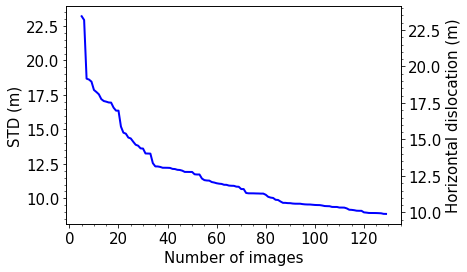

In [77]:
plt.rcParams["font.size"] = "15"

inc_angle_s = np.deg2rad(np.float(metadata_s['CENTER_INCIDENCE_ANGLE']))
heading_angle_s = np.deg2rad(np.float(metadata_s['HEADING']))

dz = np.mean(np.array(dem_err_std_s), axis=0).flatten()
dx = dz * (1 / np.tan(inc_angle_s)) * np.cos(heading_angle_s)
dy = dz * (1 / np.tan(inc_angle_s)) * np.sin(heading_angle_s)

dr = np.sqrt(dx**2 + dy**2)
#dr = np.mean((np.array(dr)), axis=0).flatten()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#ax1.plot(nums, np.sqrt(np.mean((np.array(deltaz_s)-build_height)**2, axis=0)).flatten(), 'blue', linewidth=2.0)

ax1.plot(nums, np.mean(np.array(dem_err_std_s), axis=0).flatten(), 'blue', linewidth=2.0)


ax1.set_ylabel('STD (m)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax1.set_xlabel('Number of images')
ax2.set_ylim(np.min(dr), np.max(dr))

ax1.yaxis.get_ticklocs(minor=True)     # []
ax1.minorticks_on()

ax2.yaxis.get_ticklocs(minor=True)     # []
ax2.minorticks_on()
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylabel('Horizontal dislocation (m)', color='black')

plt.savefig(out_dir +'/RMS_DEM_error.png', bbox_inches='tight', dpi=300) 
